## ライブラリのインポート

In [1220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## データの読み込み

In [1221]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
df = pd.concat([train, test], axis=0, ignore_index=True)

## 前処理

In [1222]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = pd.to_datetime(df['datetime']).dt.strftime('%Y')
df['month'] = pd.to_datetime(df['datetime']).dt.strftime('%m')
df['day'] = pd.to_datetime(df['datetime']).dt.strftime('%d')
df['weekday'] = pd.to_datetime(df['datetime']).dt.strftime('%a')
df['hour'] = pd.to_datetime(df['datetime']).dt.strftime('%H')

df = df.sort_values('datetime')
df['moving_ave_3'] = df['count'].rolling(window=3, center=True).mean() #3日間移動平均
df['moving_ave_5'] = df['count'].rolling(window=5, center=True).mean() # 5日間移動平均
df['moving_ave_7'] = df['count'].rolling(window= 7, center=True).mean() # 7日間移動平均
df['moving_ave_14'] = df['count'].rolling(window=3, center=True).mean() #14日間移動平均
# df.dropna(inplace=True)

df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'weekday', 'hour', 'moving_ave_3',
       'moving_ave_5', 'moving_ave_7', 'moving_ave_14'],
      dtype='object')

In [1223]:
# df.iloc[400:450,:]

## カラムの選択

In [1224]:
df = df[
    [
        # 'datetime',
        # 'season',
        'temp',    
        # 'humidity',
        # 'windspeed',
        'holiday',
        'workingday',
        'weather',
        # 'month',
        'weekday',
        'hour',
        'count',
        'moving_ave_3',
        # 'moving_ave_7',
        # 'moving_ave_14',
    ]
]

In [1225]:
df = pd.get_dummies(df, columns=[
    # 'season',
    # 'month',
    'weekday',
    'hour',
    'weather',
])

## 学習データの準備

In [1226]:
df.columns

Index(['temp', 'holiday', 'workingday', 'count', 'moving_ave_3', 'weekday_Fri',
       'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu',
       'weekday_Tue', 'weekday_Wed', 'hour_00', 'hour_01', 'hour_02',
       'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08',
       'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'weather_1', 'weather_2', 'weather_3',
       'weather_4'],
      dtype='object')

In [1227]:
df = df.sort_index()

In [1228]:
train = df.iloc[:len(train),:].copy()
train['count'] = train['count'].astype('int64')

In [1229]:
test = df.iloc[len(train):,:].copy()
test.drop(['count'], axis=1, inplace=True)
test = test.reset_index(drop=True)

In [1230]:
y = train.loc[:,["count"]].values
train.drop(['count'], axis=1, inplace=True)
X = train.values

In [1231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
y_train = y_train.ravel()   # 1    2d array -> 1d array 
y_test  = y_test.ravel()    # 2    2d array -> 1d array 

## モデル構築

In [1232]:
model = lgb.LGBMRegressor(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [1233]:
# スコアを表示。小さいほどよい
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [1234]:
# from sklearn.linear_model import Lasso                         # LASSO回帰のクラスを読み込み
# model = Lasso(alpha=1)                                # LASSO回帰のインスタンスを生成
# model = model_lasso.fit(X_train, y_train)                                      # データを学習させる
# y_pred = model.predict(X_test)

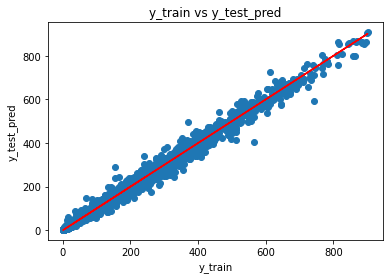

In [1235]:
# 散布図を描画(真値 vs 予測値)
plt.plot(y_test, y_test, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
plt.scatter(y_test, y_pred) # 散布図のプロット
plt.xlabel('y_train') # x軸ラベル
plt.ylabel('y_test_pred') # y軸ラベル
plt.title('y_train vs y_test_pred') # グラフタイトル
plt.show()

In [1236]:
print("test score: ",rmsle(y_test, model.predict(X_test)))
print("train score: ",rmsle(y_train, model.predict(X_train)))

test score:  0.1990635935326299
train score:  0.186714685386302


In [1237]:
# y_t = pd.DataFrame(model.predict(X_train))
# y_t.describe()

In [1238]:
y_p = pd.DataFrame(model.predict(X_test))
y_p.describe()

,0
count,2722.000000
mean,194.157506
std,179.912019
min,2.045482
25%,44.826894
50%,151.370779
75%,287.455982
max,907.515186


In [1239]:
# y_p

In [1240]:
y_p.loc[y_p[0]<0].count()

0    0
dtype: int64

In [1241]:
test_pred = model.predict(test)
test_pred = pd.DataFrame(test_pred, columns=['count'])
test_pred['count'] = test_pred['count'].astype('int64')

submission  = pd.read_csv('input/sampleSubmission.csv')
submission = pd.DataFrame(submission['datetime'])
submission = pd.concat([submission, test_pred], axis=1)

# submission['count'].sum()/submission['count'].count()

In [1242]:
# df['count'].describe()

In [1243]:
submission.loc[submission['count']<0, 'count'].count()
submission.loc[submission['count']<0, 'count'] = 0

In [1244]:
# submission.loc[submission['count']<0, 'count'].count()

In [1245]:
# submission.head(20)

In [1246]:
submission.describe()

,count
count,6493.000000
mean,64.574311
std,16.501038
min,21.000000
25%,56.000000
50%,63.000000
75%,76.000000
max,109.000000


In [1247]:
submission.to_csv('output/submission.csv',index=False)